In [1]:
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

<IPython.core.display.Javascript object>

# ATS

In [64]:
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_control
try:
    ATS.close()
    ATS_controller.close()
except:
    pass
reload(ATS_driver)
reload(ATS_control)

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_control.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_name='ATS',
                                                           server_name='Alazar_server')

ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=135,
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')
ATS_controller.set_acquisitionkwargs(buffer_timeout=5000,
                                     samples_per_record=50000,
                                     records_per_buffer=1,
                                     buffers_per_acquisition=1,
                                     channel_selection='AC')

In [65]:
try:
    SIM900.close()
except:
    pass
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
reload(SIM900_driver)
SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
TG, LB, RB, TGAC, SRC, _, DS, DF = [eval('SIM900.chan{}'.format(i)) for i in range(1,9)]


In [5]:
for i in range(1,9):
    print('channel {}: {} V'.format(i, eval('SIM900.chan{}()'.format(i))))

channel 1: 15.54 V
channel 2: 3.8 V
channel 3: 3.8 V
channel 4: 1.675 V
channel 5: 0.25 V
channel 6: 0.0 V
channel 7: 2.646 V
channel 8: 2.646 V


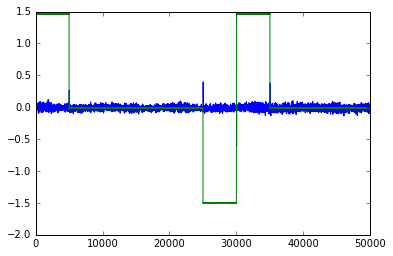

In [74]:
# ATS_controller.average_mode('point')
result = ATS_controller.acquisition()

plt.figure()
plt.plot(result[0])
plt.plot(result[1])

In [75]:
TGAC()

1.687

In [ ]:
# Finally show that this instrument also works within a loop
dummy = parameter.ManualParameter(name="dummy")
data = qc.Loop(dummy[0:50:1]).each(acquisition_controller.acquisition).run(name='AlazarTest')
qc.MatPlot(data.acquisition_controller_acquisition)

In [77]:
loc_provider = qc.data.location.FormatLocation(fmt='data/{date}/#{counter}_{name}_{time}')
qc.data.data_set.DataSet.location_provider=loc_provider

data = qc.Loop(TGAC.sweep(1.62,1.625,0.001), delay=0.003).each(
    ATS_controller.acquisition).run(name='testsweep')
plotQ = qc.QtPlot()
plotQ.add(data.ATS_control_acquisition)

DataSet:
   mode     = DataMode.PULL_FROM_SERVER
   location = 'data/2016-08-19/#002_testsweep_11-48-24'
   <Type>   | <array_id>              | <array.name> | <array.shape>
   Setpoint | SIM900_chan4_set        | chan4        | (6,)
   Measured | ATS_control_acquisition | acquisition  | (6,)
started at 2016-08-19 11:48:25


In [79]:
ATS_controller.acquisition()

[array([ 0.24511719,  0.23754883,  0.23046875, ...,  0.22998047,
         0.22924805,  0.2331543 ]),
 array([ 1.47290039,  1.47583008,  1.47363281, ..., -0.01806641,
        -0.01611328, -0.01855469])]

In [200]:
SIM900.close()